# Analysis of deep reinforcement learning on optimizing limit order placement

This notebook aims to analyse the capabilities of deep reinforcement learning on the optimization problem: *limit order placement* as investigated [here](http://localhost:8888/notebooks/order_execution_behaviour.ipynb). The pirmary goal remains the same: *"How can one one buy (respectively sell) I assets within a time horizon H while spending as little (respectively receiving the most) of the counter asset" [1]*. 

Of particular interest is whether deep reinforcement learning will perform better than the exploration proceeded with the use of the Q-Learning algorithm, which was evaluated [here](http://localhost:8888/notebooks/analysis_average_price.ipynb).
With that said, the approach which is about to be investigated relies on the feature set derived from the order book only (e.g. only market variables being used and no private variables), which was described in detail [here](http://localhost:8888/notebooks/orderbook_features.ipynb) and originally derived from the observation on the data being hidden in a limit order book as investigated [here](http://localhost:8888/notebooks/understanding_events.ipynb).
The method in use is a [DQNAgent](http://keras-rl.readthedocs.io/en/latest/agents/dqn/) with a basic neural network built with [Keras](https://keras.io/).

We will first create artificial data sets which immitate order books and see whether or not optimal order placement can be learned in such a schematic setting. Later we consider a historical data set which describes order book states over time that have occurend on the Bitfinex exchange. The trading pair of our choice is USD/BTC.

In [1]:
% cd ..

/Volumes/Data/dev/ctc-executioner


In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

## Environment

At first we create the execution environment which is an instance of an OpenAI Gym environment.
Among other components, this implementation involves the order book and match engine built over the course of this project.

In [3]:
import gym
import gym_ctc_executioner
env = gym.make("ctc-executioner-v0")

[2018-04-19 02:47:23,587] Making new env: ctc-executioner-v0


The environement is flexible as it allows to be configured to our needs.
Essentially we are interested in selling 1 BTC over the course of 100 seconds. Thereby we consider 25 order book states as our feature dimension and limit the book size to 10 positions per side of the book.

In [4]:
from order_side import OrderSide

env._configure(orderbook=None,
               side=OrderSide.SELL,
               levels=(-50, 50, 1), # Action -$5 -> +$5
               T=(0, 100, 10), # 100 seconds time horizon with 10 seconds segmentation
               I=(0, 1, 0.1), # 1 BTC inventory with 0.1 BTC segmentation
               lookback=25, # 25 order book states lookback
               bookSize=10) # 10 levels considered for each state and side of the order book

The resulted observation space has the shape: `(2*lookback, bookSize, 2)`

In [5]:
env.observation_space.shape

(50, 10, 2)

## Model

We can now define a model which will act as an approximator for the observed states and subsequently will predict the appropriate action to be taken.
With the help of the Keras library we create a neural network with the input layer set according to the shape of the observation space, 1 hidden layer of size 40 neurons, and an output layer of size accoring to the number of possible actions (101).

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam, SGD

def createModel():
    model = Sequential()
    model.add(Flatten(input_shape=(1,1,)+env.observation_space.shape))
    model.add(Dense(4*env.bookSize))
    model.add(Activation('relu'))
    model.add(Dense(len(env.levels)))
    model.add(Activation('linear'))
    model.summary()
    return model

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python/3.6.4_3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [7]:
model = createModel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                40040     
_________________________________________________________________
activation_1 (Activation)    (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 101)               4141      
_________________________________________________________________
activation_2 (Activation)    (None, 101)               0         
Total params: 44,181
Trainable params: 44,181
Non-trainable params: 0
_________________________________________________________________


## Agent

At this stage the environment is prepared and we can configure the agent.
Using the Keras Deep Learning toolbox we define a Deep Q-Network Agent that makes use of our previously defined model as its state approximator within a Q-Learning setting.
The DQNAgent performs *experience replay* and requires a memory to store the agent's experiences. 
The agent further demands a policy, which we will set to an *epsilon greedy policy* and decreases the *epsilon* over the course of the training to 0.1.

In [8]:
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

def createAgent(model):
    policy = EpsGreedyQPolicy()
    memory = SequentialMemory(limit=5000, window_length=1)
    dqn = DQNAgent(model=model, nb_actions=len(env.levels), memory=memory, nb_steps_warmup=100, target_model_update=1e-2, policy=policy)
    dqn.compile(Adam(lr=1e-3), metrics=['mae'])
    return dqn
    
agent = createAgent(model)
agent.get_config()

{'batch_size': 32,
 'delta_clip': inf,
 'dueling_type': 'avg',
 'enable_double_dqn': True,
 'enable_dueling_network': False,
 'gamma': 0.99,
 'memory': {'class_name': 'SequentialMemory',
  'config': {'ignore_episode_boundaries': False,
   'limit': 5000,
   'window_length': 1}},
 'memory_interval': 1,
 'model': {'class_name': 'Sequential',
  'config': [{'class_name': 'Flatten',
    'config': {'batch_input_shape': (None, 1, 1, 50, 10, 2),
     'dtype': 'float32',
     'name': 'flatten_1',
     'trainable': True}},
   {'class_name': 'Dense',
    'config': {'activation': 'linear',
     'activity_regularizer': None,
     'bias_constraint': None,
     'bias_initializer': {'class_name': 'Zeros', 'config': {}},
     'bias_regularizer': None,
     'kernel_constraint': None,
     'kernel_initializer': {'class_name': 'VarianceScaling',
      'config': {'distribution': 'uniform',
       'mode': 'fan_avg',
       'scale': 1.0,
       'seed': None}},
     'kernel_regularizer': None,
     'name': 'de

## Run on artificial data

We now provide an artificially created order book to the agent and see whether it is possible to optimize in such a setting.


The first order book we provide results in a linear down trend decreasing from \$10'000 to \$9'940 within 10 minutes – resulting in a price fall of \$6 per minute, respectively \$0.1 per second.
For every state in the order book 50 levels are available, each with a price decrease (repectively increase for asks) of $0.1 and a fixed quantity of 0.1 BTC.

Number of states: 601
Duration: 600.0
States per second: 1.0016666666666667
Change of price per second: 0.1


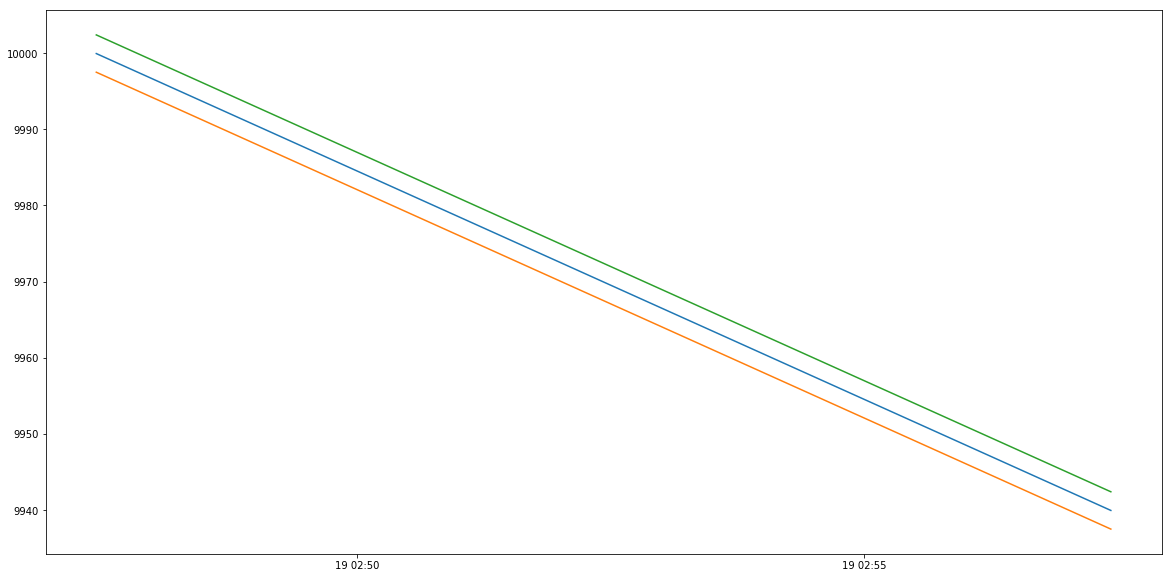

In [9]:
plt.rcParams["figure.figsize"] = (20,10)

import datetime
from orderbook import Orderbook

orderbook = Orderbook()
config = {
    'startPrice': 10000.0,
    'endPrice': 9940.0,
    'levels': 25,
    'qtyPosition': 0.1,
    'startTime': datetime.datetime.now(),
    'duration': datetime.timedelta(minutes=10),
    'interval': datetime.timedelta(seconds=1)
}
orderbook.createArtificial(config)
orderbook.summary()
orderbook.plot(show_bidask=True)

In [10]:
env.setOrderbook(orderbook)

After providing the environment access to the order book, we can start the training.
But before doing so, we can already take a guess on what the optimal action might be, given the known price trend:
- If an execution is scheduled with a time horizon of 100 seconds, the price decrease for the asset is \$10.00, which would be the premium for a market order at the end of the period.
- We have a maximum of 10 steps (order placement & cancellation) available and therefore the price decrease per 10 seconds is \$1.00.
- Posting a negative limit order (on the buyer side) would not result in an execution as the price goes down only.
- Selling 1.0 BTC immediately would result in a premium of 1/10 \* (0.1+0.2+0.3+0.4+0.5+0.6+0.7+0.8+0.9+1.0) = \$0.55 with limit >= 10.
- Step-wise selling with limit = 1 would result in partial trades of quantity 0.1 with a total premium of (0.1\*0.1, 0.1\*1.1, ..., 0.1\*9.1) = \$4.6

Hence, it would be best if the action is placed in the range of +10 such 1.0 BTC is being bought immediately.

Let us finally train the agent. For now we use 1000 steps and see whether or not more training will be required.

In [21]:
from agent_utils.action_plot_callback import ActionPlotCallback
from agent_utils.live_plot_callback import LivePlotCallback

cbs_train = []
#cbs_train = [LivePlotCallback(nb_episodes=100, avgwindow=20)]
train = None

agent = createAgent(model)
train = agent.fit(env, nb_steps=1000, visualize=True, verbose=0, callbacks=[])

Before we analyse the results, let us define a helper function which prints the reward of the episodes.

In [17]:
import numpy as np

def plotTrain(train):
    episodes = train.history['episode_reward']
    nrEpisodes = len(episodes)
    plt.plot(range(nrEpisodes), episodes)
    plt.show()

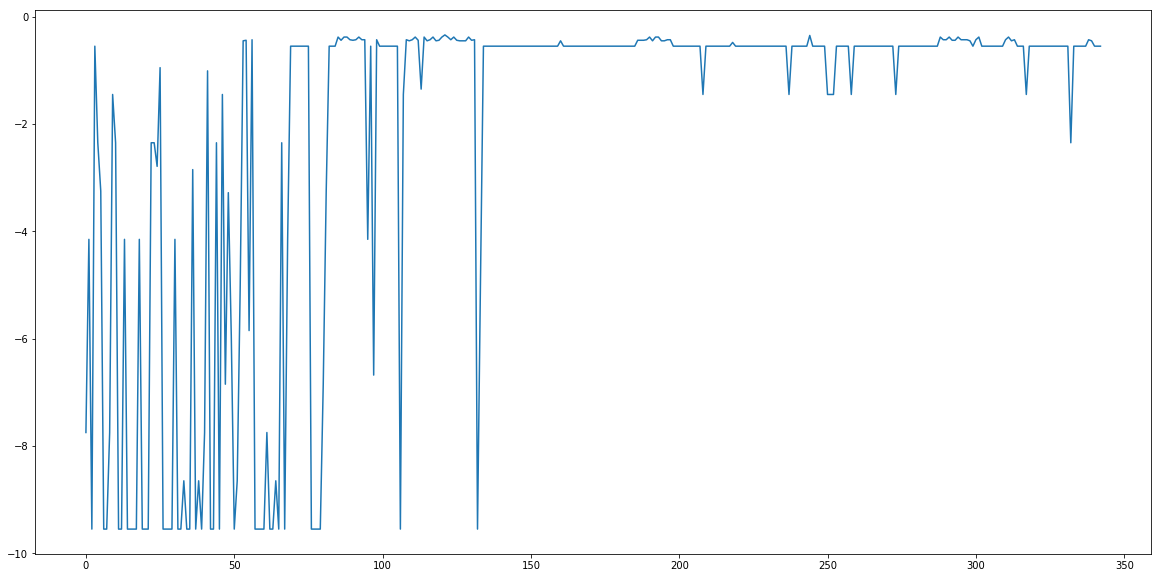

In [18]:
plotTrain(train)

As we can see, the DQN is in fact capable of optimizing the order placement within this relatively simple and artificial setting.
After approximately 75 episodes it finds near optimal policy and continues exploring. After 125 episodes it seems the function approximation barely results in a change of the policy anymore and the reward became stable.

We are curious what the agent effectively learned and therefore we want to run tests using the learned policy.
For illustration clarity we only run 5 executions but it will provide insight into what the agent has learned.

Testing for 5 episodes ...
Episode 1: reward: -0.550, steps: 1
Episode 2: reward: -0.550, steps: 1
Episode 3: reward: -0.550, steps: 1
Episode 4: reward: -0.550, steps: 1


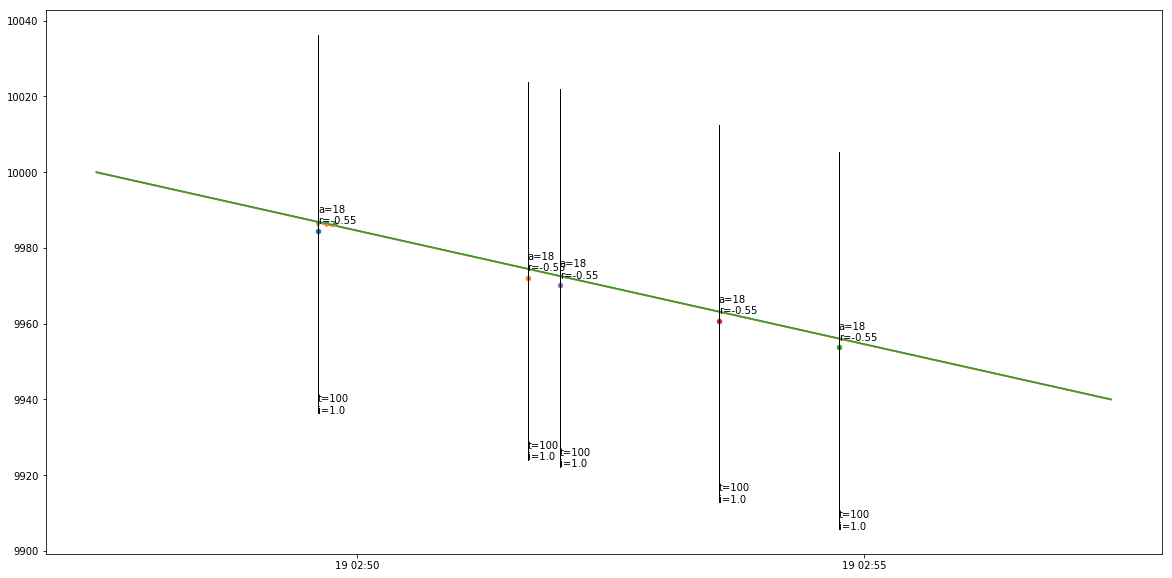

Episode 5: reward: -0.550, steps: 1


In [23]:
nrTest = 5
cbs_test = [ActionPlotCallback(nb_episodes=nrTest)]
agent.test(env, nb_episodes=nrTest, visualize=True, verbose=2, callbacks=cbs_test)

The figure above shows the 5 executions, each with the same limit order placement.
The agent decided that the action which results in a limit level of +18 is the most suitable for all the executions, as this results in an immediate sell of the assetes. 
This is in fact the optimal strategy as every action >10 will result in an immediate sell of the entire stock.
Thus, the DQN agent was able to learn perfectly.

For illustration pruposes the output below shows the resulted trades from the last execution. We can see that partial trades of quantity 0.1 and with a price decrease of 0.1 have been made until 1.0 BTC was executed.

In [20]:
env.execution.getTrades()

[2018-04-19 02:51:30.929552,OrderSide.SELL,OrderType.LIMIT,0.1,9975.4,0.0,
 2018-04-19 02:51:30.929552,OrderSide.SELL,OrderType.LIMIT,0.1,9975.3,0.0,
 2018-04-19 02:51:30.929552,OrderSide.SELL,OrderType.LIMIT,0.1,9975.2,0.0,
 2018-04-19 02:51:30.929552,OrderSide.SELL,OrderType.LIMIT,0.1,9975.1,0.0,
 2018-04-19 02:51:30.929552,OrderSide.SELL,OrderType.LIMIT,0.1,9975.0,0.0,
 2018-04-19 02:51:30.929552,OrderSide.SELL,OrderType.LIMIT,0.1,9974.9,0.0,
 2018-04-19 02:51:30.929552,OrderSide.SELL,OrderType.LIMIT,0.1,9974.8,0.0,
 2018-04-19 02:51:30.929552,OrderSide.SELL,OrderType.LIMIT,0.1,9974.7,0.0,
 2018-04-19 02:51:30.929552,OrderSide.SELL,OrderType.LIMIT,0.1,9974.6,0.0,
 2018-04-19 02:51:30.929552,OrderSide.SELL,OrderType.LIMIT,0.1,9974.5,0.0,
 2018-04-19 02:51:30.929552,OrderSide.SELL,OrderType.LIMIT,2.7755575615628914e-17,9974.4,0.0]

[1]: https://www.cis.upenn.edu/~mkearns/papers/rlexec.pdf

[1] https://www.cis.upenn.edu/~mkearns/papers/rlexec.pdf